In [ ]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

## Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы.

In [ ]:
#Следующая строка отключает вывод ячейки
%%capture
import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Сверточные нейронные сети

### Ядра
Посмотрим, как различные ядра свёртки преобразуют изображения.

In [ ]:
!wget https://isu.ru/export/sites/isu/ru/university/.galleries/images/belyi_dom_dl.jpg_1640987435.jpg -O sample_photo.jpg

--2023-06-15 15:40:01--  https://isu.ru/export/sites/isu/ru/university/.galleries/images/belyi_dom_dl.jpg_1640987435.jpg
Resolving isu.ru (isu.ru)... 194.190.238.182
Connecting to isu.ru (isu.ru)|194.190.238.182|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 195448 (191K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>] 190.87K   408KB/s    in 0.5s    

Last-modified header invalid -- time-stamp ignored.
2023-06-15 15:40:03 (408 KB/s) - ‘sample_photo.jpg’ saved [195448/195448]



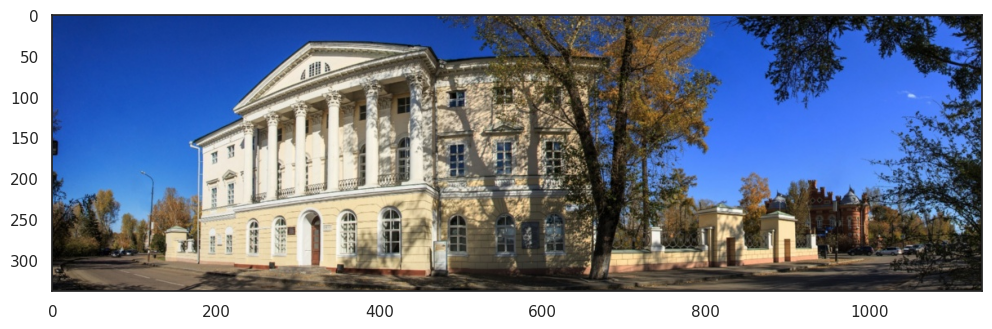

In [ ]:
import cv2

sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Посмотрите, как различные свертки влияют на фото:

A:
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
B:
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
C:
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
D:
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
E:
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
F:
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Попробуйте свои варианты.

In [ ]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)

A = [
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
]

B = [
    [0, 1, 0],
    [0, -2, 0],
    [0, 1, 0]
]

C = [
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
]

D = [
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
]

E = [
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
]

_F = [
    [0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]
]


kernel = torch.tensor(_F).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

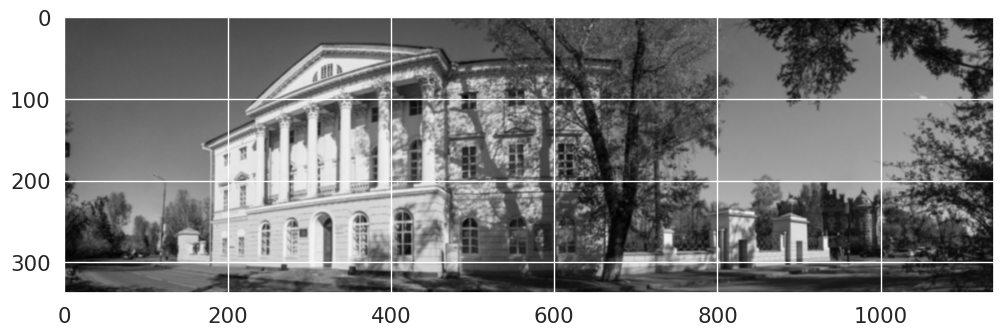

In [ ]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 1.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1. Размытие - F

2. Увеличение резкости - E

3. Тождественное преобразование - A

4. Выделение вертикальных границ - C

5. Выделение горизонтальных границ - B

6. Выделение границ - D

### Задание. Реализуйте LeNet

Если сделать параметры сверток обучаемыми, то можно добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную в 1998 году.
На этот раз используйте модульную структуру (без помощи класса Sequential).

Нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3) # 26 26 6
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 13 13 6
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3) # 11 11 16
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 5 5 16
        self.fc1 = nn.Linear(5 * 5 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(
            F.relu(self.conv1(x))
        )
        x = self.pool2(
            F.relu(self.conv2(x))
        )
        # print(x.shape)

        x = x.view(-1, 5 * 5 * 16) # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [ ]:
# TODO

# learn
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
                # TODO установите режим ``train`` для модели
                # и вычислите выходы, не забудьте zero_grad!
                model.train()
                optimizer.zero_grad()
                output = model(x_batch)
            else:
                # TODO установите режим ``eval`` для модели
                # вычислите выходы
                model.eval()
                output = model(x_batch)
            preds = output.argmax(-1)
            # TODO посчитайте количество верных ответов сети
            correct = sum(preds == y_batch)
            # TODO общее количество элементов в батче
            all = len(output)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                # TODO вычислите градиенты
                # и выполните шаг оптимизатора
                loss = criterion(output, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch + 1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct / epoch_all}")
        accuracy[k].append(epoch_correct / epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8692574786324786
Loader: valid. Accuracy: 0.9665464743589743
Epoch: 2
Loader: train. Accuracy: 0.9659455128205128
Loader: valid. Accuracy: 0.9748597756410257
Epoch: 3
Loader: train. Accuracy: 0.9763788728632479
Loader: valid. Accuracy: 0.9793669871794872
Epoch: 4
Loader: train. Accuracy: 0.981620592948718
Loader: valid. Accuracy: 0.9806690705128205
Epoch: 5
Loader: train. Accuracy: 0.9850260416666666
Loader: valid. Accuracy: 0.9816706730769231
Epoch: 6
Loader: train. Accuracy: 0.9871461004273504
Loader: valid. Accuracy: 0.9821714743589743
Epoch: 7
Loader: train. Accuracy: 0.9887486645299145
Loader: valid. Accuracy: 0.9833733974358975
Epoch: 8
Loader: train. Accuracy: 0.9905515491452992
Loader: valid. Accuracy: 0.9847756410256411
Epoch: 9
Loader: train. Accuracy: 0.9915865384615384
Loader: valid. Accuracy: 0.985176282051282
Epoch: 10
Loader: train. Accuracy: 0.9930722489316239
Loader: valid. Accuracy: 0.9844751602564102


In [ ]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

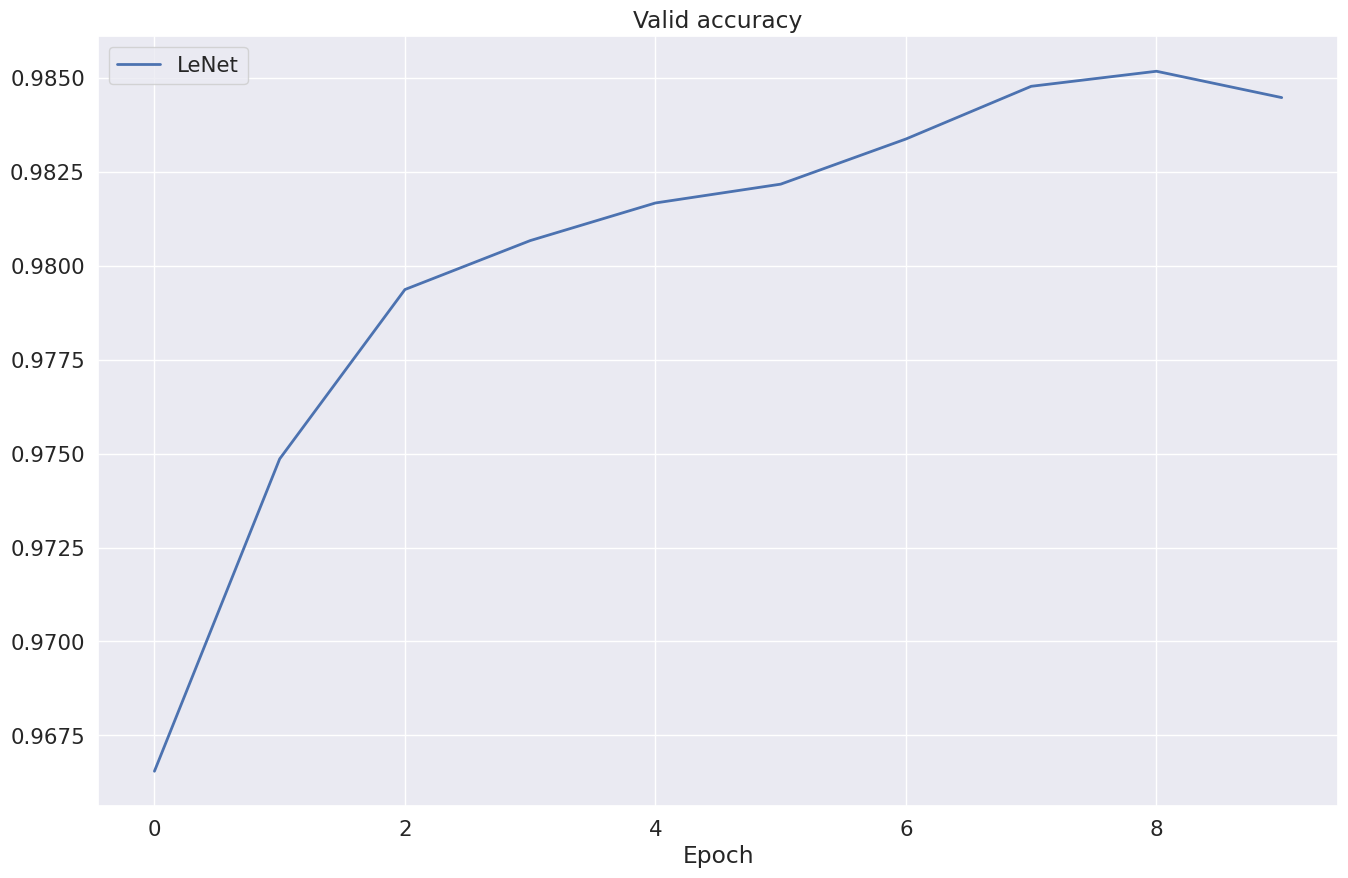

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
#Здесь можно запустить код из предыдущего задания, чтобы сделать сравнение
#plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
#plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
#plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [ ]:
f'{lenet_accuracy[-1]:.2f}'

'0.98'

**Вопрос 2**
Какое значение `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.98